Using ultranest for inference

In [1]:
#%load_ext autoreload
#%autoreload 2
import warnings

warnings.filterwarnings('ignore')

import os, sys
root_dir = os.path.dirname(os.path.abspath(''))
if not root_dir in sys.path: sys.path.append(root_dir)

In [2]:
import numpy as np
import quadpy
import ultranest
from ultranest.plot import cornerplot

import matplotlib.pyplot as plt
from collections import Counter
import json
import pickle

import scipy as sp
from scipy.special import binom as sp_binom
from scipy.special import factorial as sp_factorial

import time

In [3]:
from inference import *
from DM_theory import *
from empirical.readData import *
from empirical.model import *

In [4]:
def p_nu(nu,gamma,delta,nu_max):
    
    #print(f"gamma={gamma}, delta={delta}, nu_max={nu_max}")
    return gamma / ( nu_max * np.sqrt( -np.pi * np.log( nu / nu_max ) ) ) * \
        np.exp( - delta**2/2.) * ( nu / nu_max )**(gamma**2 - 1) * \
        np.cosh( gamma * delta * np.sqrt( -2 * np.log( nu / nu_max) ) )

def poisson_spikes(nu,N,T_total):
    #print("poisson:",nu,T_total)
    return np.exp(N*np.log(nu*T_total) - np.log(sp_factorial(N)) - nu*T_total)
    #return (nu*T_total)**N / sp_factorial(N) * np.exp(-nu*T_total)

In [6]:
from scipy.integrate import quad


def f(nu,gamma,delta,nu_max,N_AP,T_total,loop=False):
    #print(nu_max)
    if loop:
        return p_nu(nu,gamma,delta,nu_max) * poisson_spikes(nu,N_AP,T_total)
    else:
        return p_nu(nu,gamma,delta,nu_max) * poisson_spikes(nu,N_AP[:,np.newaxis],T_total)

class Inference:

    dataLoaded = False
    paras = {}

    def __init__(self):

        os.environ['MKL_NUM_THREADS'] = '2'
        os.environ['OPENBLAS_NUM_THREADS'] = '2'
        os.environ['OMP_NUM_THREADS'] = '2'
        
        self.param_names = ['gamma','delta','nu_max']
        
        self.prior = {
            'gamma': {'mu': 1.5, 'std':0.5, 'lower':0., 'upper': np.inf},
            'delta': {'mu': 4, 'std':0.5, 'lower': 0., 'upper': np.inf},
            'nu_max': {'mu': 30., 'std':20, 'lower': 10., 'upper': np.inf},
        }
        self.ct=0
    
    
    def load_data(self, dataType='empirical', filePath='../data/BuscheLab/2P_data.xlsx',include_silent=False):

        self.mP = ModelParams(dataType, filePath=filePath, population_keys=['*mouse_type','animal'])
        self.data_df = self.mP.regularize_rates()

        self.data = self.data_df.to_numpy()

        N_zeros = (self.data==0).sum()
        #print(f'zeros in data: {N_zeros}')
#        self.data[self.data==0] = np.random.rand(N_zeros)*1./600
        #if include_silent:
        #    T = 600.
        #    self.data[self.data<=1./T] = -np.log(1-np.random.rand((self.data<=1./T).sum()))/T

        self.data_mask = ~np.isnan(self.data) & (self.data>0)

        self.dataLoaded = True
        
        
        ## prepare data such that we have all necessary values
        data_observed = self.prepare_data(0)


    def prepare_data(self,animal=0,T_total=10.,withZeros=True):

        N_AP = self.data*T_total
        
        N_AP_max = int(np.nanmax(N_AP))+1
        data_observed = {'n_animals': [],
                         #'N_AP': np.zeros((N_AP_max,N_AP.shape[1]),dtype="int64"),
                         'k_animals': np.zeros((N_AP.shape[1],N_AP_max),dtype="int64")
                        }
        
        for a,N in enumerate(N_AP.T):
        
            N = N[~np.isnan(N)].astype('int64')
            N_ct = Counter(N)
            data_observed['k_animals'][a,list(N_ct.keys())] = list(N_ct.values())
        
            data_observed['n_animals'].append(len(N))
            
        #rint(f'data: {self.data}')
        #rint(f'data observed: {data_observed}')
        #self.data_obs = data_observed
        
        self.n = data_observed['n_animals'][animal]
        self.animal = animal
        
        if withZeros:
            self.k_AP = data_observed['k_animals'][animal][:,np.newaxis]#[self.N_AP]#,np.newaxis]
            self.N_AP = np.arange(0,N_AP_max)[:,np.newaxis]
        else:
            self.N_AP = np.where(data_observed['k_animals'][animal])[0]#[:,np.newaxis]
            self.k_AP = data_observed['k_animals'][animal,self.N_AP][:,np.newaxis]
            self.N_AP = self.N_AP[:,np.newaxis]
        
        self.rates = I.data[I.data[:,animal]>0,animal]
            
        #print(self.N_AP.shape,self.k_AP.shape)
        self.T_total = T_total
        
        return data_observed
    
    def setPriorTransform(self):
        def prior_transform(cube):
            # transforms random variables from uniform [0,1] distribution into actual priors
            
            
            params = np.zeros_like(cube)
            for i,var in enumerate(self.prior.keys()):
                mu = self.prior[var]['mu']
                sigma = self.prior[var]['std']
                lower = self.prior[var]['lower']
                upper = self.prior[var]['upper']
                params[...,i] = sp.stats.truncnorm.ppf(cube[...,i],(lower-mu)/sigma,(upper-mu)/sigma,mu,sigma)
            #delta = sp.stats.truncnorm.ppf(cube[1],0,np.inf,self.prior['delta']['mu'],self.prior['delta']['std'])
            #nu_max = sp.stats.truncnorm.ppf(cube[2],0,np.inf,self.prior['nu_max']['mu'],self.prior['nu_max']['std'])

            #return [gamma,delta,nu_max]
            return params
        return prior_transform
        
    def setLogLikelihood(self,counts=True):
        def loglikelihood(params):
            ## define likelihood based on parameters, with data provided from context

            # integrate rho_nu with poisson
            logl = np.zeros(params.shape[0])
            binom = sp_binom(self.n,self.k_AP)#[:,np.newaxis]
            
            if counts:
                p_N_AP_arr = np.zeros((self.N_AP.shape[0],params.shape[0]))
                for i,(gamma,delta,nu_max) in enumerate(params):
                    fail = False
                    if nu_max < self.rates.max():
                        continue

                    eps_pow = -8
                    while True:
                        if eps_pow==-4:
                            #print('tolerance too high - breaking!')
                            fail = True
                            break
                        try:
                            p_N_AP_arr[:,i] = quadpy.quad(f,0,nu_max,
                                    args=(gamma,delta,nu_max,self.N_AP,self.T_total,False),
                                    epsabs=10**eps_pow, epsrel=10**eps_pow,
                                    limit=100)[0][:,0]
                                    #print(p_N_AP_arr)
                                    #print(p_N_AP_arr.shape)
                            break
                        except:
                            eps_pow += 1

                # calculate chance to appear k times
                p_k = binom * p_N_AP_arr**self.k_AP * (1-p_N_AP_arr)**(self.n - self.k_AP)
                p_k[p_k==0] = np.exp(-100.)
                logl = np.log(p_k).sum(axis=0)
            
            else:
                ## p_silent
                gamma = params[:,0]
                delta = params[:,1]
                nu_max = params[:,2]
                
                p_nonsilent = p_nu(self.rates[np.newaxis,:],gamma[:,np.newaxis],delta[:,np.newaxis],nu_max[:,np.newaxis])
                logp_nonsilent = np.log(p_nonsilent).sum(axis=1)
                #print(logp_nonsilent)
                log_binom = np.log(binom[0])
                for i,(gamma,delta,nu_max) in enumerate(params):
                    if nu_max < self.rates.max():
                        #print('not possible, skipping!')
                        logl[i] = -10000
                        continue
                    try:
                        p_silent = quad(f,0,nu_max,args=(gamma,delta,nu_max,0,self.T_total,True),full_output=1)[0]
                    except:
                        logl[i] = -10000
                        continue
                    logp_silent = np.log(p_silent)
                    logp_k = log_binom + logp_silent*self.k_AP[0,0] + np.log(1-p_silent)*(self.n - self.k_AP[0,0])
                    
                    #if (p_k==0):
                    #print("--- failed ---")
                    #print(p_silent,logp_k)
    
                    #print('paras:',gamma,delta,nu_max)
                        
                    logl[i] = logp_k + logp_nonsilent[i]
                    #print(p_k.shape,p_nonsilent.shape)
                    #print(p_silent,p_k,p_nonsilent)
                    
                    
            #print(p_N_AP_arr.shape,p_k.shape)
            #print(f"log likelihood:",logl)
            logl[np.isnan(logl)] = -10000
            return logl
        return loglikelihood
    
    ## currently issues: ~99% of traces diverge -> pole is difficult to fit
    def run_on_data(self,draws=5000,tune=10000,loadPath=None,savePath=None,**kwargs):

        """
            ToDo:
                * adjust logp method, such that it calculates
                    \int_0^1/T logp(nu) dnu
                to estimate probability of 0Hz measurements, instead of point-measure at 1/T
                -> use scipy.integrate.quad
                * write documentation!
        """

        if loadPath:
            self.trace = az.from_netcdf(loadPath)
            return
        
        logl = self.setLogLikelihood(counts=True)
        priorTrafo = self.setPriorTransform()
        
        for i in range(0,I.data_df.shape[1]):
            time_start = time.time()
            self.prepare_data(i,withZeros=True)
            sampler = ultranest.ReactiveNestedSampler(
                self.param_names,
                logl,
                priorTrafo,
                log_dir=f"logs_animal_{i}",
                vectorized=True
            )
            result = sampler.run(
                show_status=True,
                min_num_live_points=400,
                max_num_improvement_loops=3
            )
            print('sampling finished')
            cornerplot(result)
            dt = time.time() - time_start
            print(f"time taken to analyze animal {i}: {dt}s")
            
        return result, sampler

In [7]:
I = Inference()
I.load_data('empirical',filePath='../../data/BuscheLab/2P_data.xlsx',include_silent=True)
#result, sampler = I.run_on_data()

column names: [['WT', '20180310A'], ['WT', '20180312A'], ['WT', '20180310B'], ['WT', '20180401'], ['LM (APLP1 KO)', '20180325 (app ko7 739)'], ['LM (APLP1 KO)', '20180325A (app ko8 740)'], ['LM (APLP1 KO)', '20180402A (app ko13 734)'], ['LM (APLP1 KO)', '20180419 (app ko14 756)'], ['cTKO', '20180309'], ['cTKO', '20180310'], ['cTKO', '20180311'], ['cTKO', '20180329'], ['cTKO', '20180329A']]


In [12]:
I.prepare_data(withZeros=True)
logl = I.setLogLikelihood(counts=True)
nu_arr = np.linspace(1,100,100)
%timeit logl(np.array([[1.25,3.6,nu] for nu in nu_arr]))
logl(np.array([[1.25,3.6,nu] for nu in nu_arr]))

3.55 s ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


array([-3268.04278116, -1751.13376506, -1122.55596405,  -793.40518083,
        -599.47354073,  -477.55579468,  -398.83017103,  -347.29476254,
        -313.09115935,  -290.0661202 ,  -274.38187257,  -263.53213458,
        -255.81996479,  -250.19543902,  -246.06784853,  -243.04961672,
        -240.80803875,  -239.07252929,  -237.68122959,  -236.55839693,
        -235.65957585,  -234.94857776,  -234.39515598,  -233.97463716,
        -233.66686945,  -233.45526344,  -233.32604829,  -233.26770996,
        -233.27055929,  -233.3263946 ,  -233.42823625,  -233.57011615,
        -233.74690837,  -233.95419223,  -234.188141  ,  -234.44543052,
        -234.72316354,  -235.01880737,  -235.33014223,  -235.655218  ,
        -235.99231731,  -236.33992411,  -236.69669683,  -237.06144466,
        -237.43311291,  -237.81076278,  -238.19355813,  -238.58075325,
        -238.97168226,  -239.36574989,  -239.76242347,  -240.16122587,
        -240.56172935,  -240.96355021,  -241.36634405,  -241.76980166,
      

In [17]:
int_args = (1.2,3.6,42.,0,10.,True)
eps_pow=-4
res = quad(f,0,int_args[2],args=int_args,full_output=1)[0]
#res2 = quadpy.quad(f,0,int_args[2],args=int_args,epsabs=10**eps_pow, epsrel=10**eps_pow,limit=100)

print(res)

0.24552105997946977


In [8]:
## I.prepare_data(withZeros=False)
logl = I.setLogLikelihood(counts=False)
trafo = I.setPriorTransform()
%timeit trafo(np.array([0.5,0.5,0.5]))
%timeit logl(np.array([[1.5,4.0,42.]])*np.ones((100,1)))

245 µs ± 1.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
731 ms ± 5.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
logl = I.setLogLikelihood(counts=False)
nu_arr = np.linspace(1,100,10)
logl(np.array([[0.85,3.6,nu] for nu in nu_arr]))

/tmp/ipykernel_55675/3224483873.py:4: RuntimeWarning: invalid value encountered in sqrt
  return gamma / ( nu_max * np.sqrt( -np.pi * np.log( nu / nu_max ) ) ) * \
/tmp/ipykernel_55675/3224483873.py:6: RuntimeWarning: invalid value encountered in sqrt
  np.cosh( gamma * delta * np.sqrt( -2 * np.log( nu / nu_max) ) )


array([-10000.        ,   -211.59306986,   -188.69531547,   -178.10453863,
         -171.75492254,   -167.45974944,   -164.34150901,   -161.96988453,
         -160.10576313,   -158.60431148])

<IPython.core.display.Javascript object>


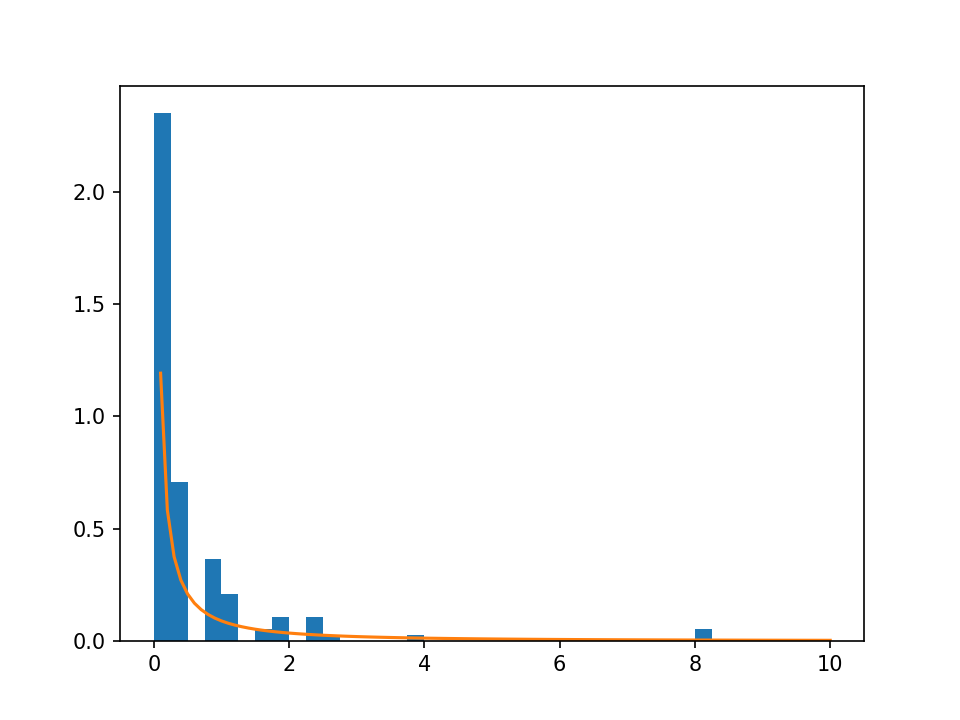

In [312]:
plt.figure()
nu_arr = np.linspace(0,10,101)
plt.hist(I.data[:,11],bins=np.linspace(0,10,41),density=True)
plt.plot(nu_arr,p_nu(nu_arr,1.0555533143135498,3.863825990269352,31.754181457663485))
#plt.ylim([-1500,-200])
plt.show()

In [139]:
import pickle
import multiprocessing as mp
from general.transformParas import *

#add_args = {'nu_I':2.,'tau_M':0.01,'tau_A':0.0002,'tau_N':0.2,'tau_G':0.02,'kappa_E':4.}
add_args = {'nu_I':2.,'tau_M':0.01,'tau_A':0.0005,'tau_N':0.2,'tau_G':0.02,'kappa_E':4.}
#add_args = {'nu_I':1.,'tau_M':0.005,'tau_A':0.001,'tau_N':0.2,'tau_G':0.02,'kappa_E':4.}
fileName = 'points_transformed'
for key,val in add_args.items():
    fileName += f"_{key}={val}"
fileName += '.pkl'
    
tP = transformParas()
tP.updateParas(add_args)

for i in range(0,13):
    time_start = time.time()
    dirName = './logs_animal_%i/run3'%i
    
    storeName = os.path.join(dirName,'results',fileName)
    data = {}
    try:
        _,result = ultranest.read_file(dirName,3)
        data['points'] = result['weighted_samples']['points'][1:-1,:]
        data['weights'] = result['weighted_samples']['weights'][1:-1]
    except:
        f = open(b'./logs_animal_%i/run3/results/points_transformed.pkl'%i,'rb')
        data = pickle.load(f)
        
    pool = mp.get_context("spawn").Pool(12)
    data['points_transformed'] = np.array(pool.starmap(tP.returnParas,zip(data['points'])))
    
    f = open(storeName,'wb')
    pickle.dump(data,f)
    dt = time.time() - time_start
    print(f"points transformed and stored to {storeName} in t={dt}s")

/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))


points transformed and stored to ./logs_animal_0/run3/results/points_transformed_nu_I=2.0_tau_M=0.01_tau_A=0.0005_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl in t=51.143847703933716s


/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))


points transformed and stored to ./logs_animal_1/run3/results/points_transformed_nu_I=2.0_tau_M=0.01_tau_A=0.0005_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl in t=49.81525683403015s


/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))


points transformed and stored to ./logs_animal_2/run3/results/points_transformed_nu_I=2.0_tau_M=0.01_tau_A=0.0005_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl in t=76.42825055122375s


/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))


points transformed and stored to ./logs_animal_3/run3/results/points_transformed_nu_I=2.0_tau_M=0.01_tau_A=0.0005_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl in t=72.10063362121582s


/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))


points transformed and stored to ./logs_animal_4/run3/results/points_transformed_nu_I=2.0_tau_M=0.01_tau_A=0.0005_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl in t=62.46276545524597s


/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))


points transformed and stored to ./logs_animal_5/run3/results/points_transformed_nu_I=2.0_tau_M=0.01_tau_A=0.0005_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl in t=67.25747227668762s


/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))


points transformed and stored to ./logs_animal_6/run3/results/points_transformed_nu_I=2.0_tau_M=0.01_tau_A=0.0005_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl in t=62.90019464492798s


/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))


points transformed and stored to ./logs_animal_7/run3/results/points_transformed_nu_I=2.0_tau_M=0.01_tau_A=0.0005_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl in t=70.44631004333496s


/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Dat

points transformed and stored to ./logs_animal_8/run3/results/points_transformed_nu_I=2.0_tau_M=0.01_tau_A=0.0005_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl in t=66.05045437812805s


/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))


points transformed and stored to ./logs_animal_9/run3/results/points_transformed_nu_I=2.0_tau_M=0.01_tau_A=0.0005_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl in t=72.39079642295837s


/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))


points transformed and stored to ./logs_animal_10/run3/results/points_transformed_nu_I=2.0_tau_M=0.01_tau_A=0.0005_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl in t=129.21940994262695s


/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))


points transformed and stored to ./logs_animal_11/run3/results/points_transformed_nu_I=2.0_tau_M=0.01_tau_A=0.0005_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl in t=69.4767849445343s


/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:59: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Dat

points transformed and stored to ./logs_animal_12/run3/results/points_transformed_nu_I=2.0_tau_M=0.01_tau_A=0.0005_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl in t=77.51173663139343s


loading data from ./logs_animal_0/run3/results/points_transformed_nu_I=1.0_tau_M=0.005_tau_A=0.001_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl
0.8836282984476637 0.8753898806481988
loading data from ./logs_animal_1/run3/results/points_transformed_nu_I=1.0_tau_M=0.005_tau_A=0.001_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl
0.8428401341212904 0.8251162696505975
loading data from ./logs_animal_2/run3/results/points_transformed_nu_I=1.0_tau_M=0.005_tau_A=0.001_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl
0.8918935995017492 0.8727342532894332
loading data from ./logs_animal_3/run3/results/points_transformed_nu_I=1.0_tau_M=0.005_tau_A=0.001_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl
0.9323436299754636 0.7077183627359235
loading data from ./logs_animal_4/run3/results/points_transformed_nu_I=1.0_tau_M=0.005_tau_A=0.001_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl
loading data from ./logs_animal_5/run3/results/points_transformed_nu_I=1.0_tau_M=0.005_tau_A=0.001_tau_N=0.2_tau_G=0.02_kappa_E=4.0.pkl
loading data from ./logs_animal_

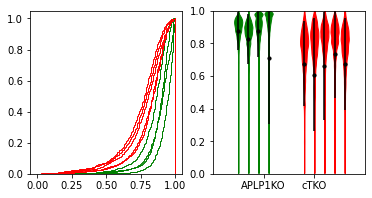

In [27]:
from scipy.stats import gaussian_kde

add_args = {'nu_I':1.,'tau_M':0.005,'tau_A':0.001,'tau_N':0.2,'tau_G':0.02,'kappa_E':4.}
fileName = 'points_transformed'
for key,val in add_args.items():
    fileName += f"_{key}={val}"
fileName += '.pkl'

fig,ax = plt.subplots(1,2,figsize=(6,3))

bins = np.linspace(0,1,201)
dbin = np.diff(bins)[0]
post = []
for i in range(13):
    #try:
    filePath = f"./logs_animal_{i}/run3/results/{fileName}"
    f = open(filePath,'rb')
    print('loading data from '+filePath)
    data_load = pickle.load(f)
    if (i>7):
        col = 'r'
        pos=2.2
        if i==8:
            post.append([])
            offset=-0.4
    elif (i>3):
        continue
        col = 'g'
        pos=0
        if i==4:
            post.append([])
            offset=-0.3
    else:
        col = 'g'
        pos=0.8
        if i==0:
            post.append([])
            offset=-0.3
    
    p = data_load['points_transformed'][:,2]
    w = data_load['weights']
    ax[0].hist(p,weights=w,
               bins=bins,
               color=col,histtype='step',density=True,cumulative=True)

    h_data, _ = np.histogram(p,bins=bins,weights=w,density=True)
    p_mean = np.dot(p[~np.isnan(p)],w[~np.isnan(p)])
    print(np.dot(h_data,bins[1:])/200,p_mean)
    h_data[h_data<(0.1)] = np.NaN
    h_data = h_data/np.nanmax(h_data) * 0.08
    #print((p*w).shape)
    #p_mean = np.nansum(p*w)
    p_var = np.sqrt(np.nansum(p**2*w) - p_mean**2)
    #offset = np.random.randn()*0.2
    
    kde = gaussian_kde(p[~np.isnan(p)], bw_method=0.1, weights=w[~np.isnan(p)])
    posterior = kde(bins[1:])
    post[-1].append(kde)
    posterior = posterior/np.max(posterior) * 0.08
    #ax[1].violinplot(data, pos, points=60, widths=0.7, showmeans=True,
    #                 showextrema=True, showmedians=True, bw_method=0.5)
    #ax[1].fill_betweenx(bins[1:],pos+offset-h_data,pos+offset,color=col)
    ax[1].fill_betweenx(bins[1:],pos+offset-posterior,pos+offset,color=col)
    ax[1].fill_betweenx(bins[1:],pos+offset,pos+offset+posterior,color=col)
    
    ax[1].scatter(pos+offset,p_mean,c='k',s=10)
    ax[1].errorbar(pos+offset,p_mean,p_var,color='k')
    offset += 0.2
    #except:
    #    pass
plt.setp(ax[1],xlim=[0,3],ylim=[0,1],xticks=[1,2],xticklabels=['APLP1KO',"cTKO"])

plt.show()

In [28]:
from scipy.stats import entropy

ent = np.zeros((len(post),len(post),5,5))*np.NaN
bins = np.linspace(0,1,101)
for animal_type in range(len(post)):
    for animal_type_compare in range(len(post)):
        for animal in range(len(post[animal_type])):
            for animal_compare in range(len(post[animal_type_compare])):
                distr_ref = post[animal_type][animal](bins)
                distr_comp = post[animal_type_compare][animal_compare](bins)
                
                distr_ref /= distr_ref.sum()
                distr_comp /= distr_comp.sum()
                
                ent[animal_type][animal_type_compare][animal][animal_compare] = \
                    entropy(distr_ref,distr_comp)

In [29]:
ent

array([[[[0.        , 0.17978529, 0.12488326, 0.42246353,        nan],
         [0.19955297, 0.        , 0.25595265, 0.77863195,        nan],
         [0.18743536, 0.48061904, 0.        , 0.32380115,        nan],
         [0.56310225, 1.20507062, 0.15309193, 0.        ,        nan],
         [       nan,        nan,        nan,        nan,        nan]],

        [[0.79555255, 0.4934466 , 0.33233159, 0.28237085, 0.65182853],
         [0.34014519, 0.18313438, 0.07893497, 0.0587586 , 0.24985976],
         [0.89985205, 0.54180935, 0.40851808, 0.36649706, 0.73232891],
         [1.71179817, 1.17831253, 1.03424038, 0.97887141, 1.48150968],
         [       nan,        nan,        nan,        nan,        nan]]],


       [[[1.06620037, 0.49767617, 0.89806375, 2.33093708,        nan],
         [0.70090212, 0.33695178, 0.60908221, 1.78544175,        nan],
         [0.44964043, 0.22579158, 0.39291966, 1.4968768 ,        nan],
         [0.39847367, 0.15413788, 0.35634893, 1.2734146 ,        nan],


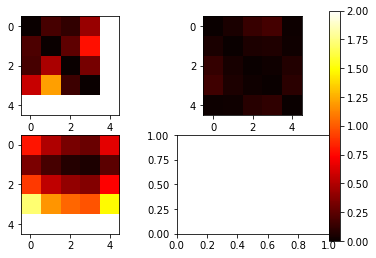

In [30]:
fig,ax = plt.subplots(2,2)
im = ax[0][0].imshow(ent[0,0],cmap='hot',clim=[0,2])
ax[0][1].imshow(ent[1,1],cmap='hot',clim=[0,2])
ax[1][0].imshow(ent[0,1],cmap='hot',clim=[0,2])
#ax[1][1].imshow(ent[1,0],cmap='hot',clim=[0,2])

cax = plt.axes([0.9, 0.1, 0.025, 0.8])
plt.colorbar(im,cax=cax)
plt.show()

<IPython.core.display.Javascript object>


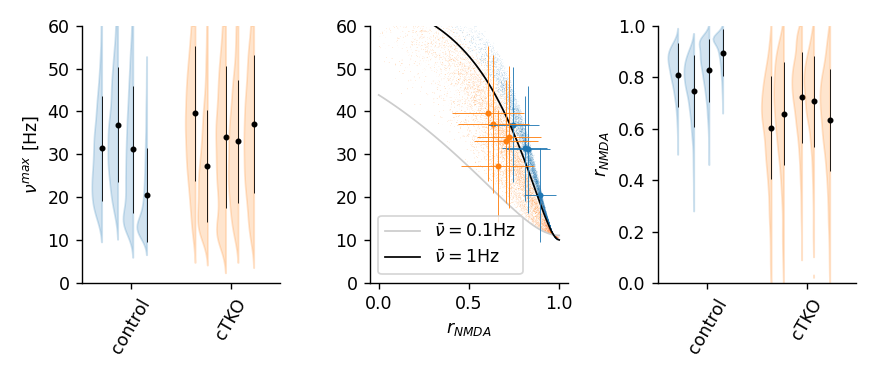

In [178]:
from scipy.stats import gaussian_kde
%matplotlib nbagg

col = ['tab:blue','b','tab:orange']

types = ['APLP1KO','WT','cTKO']#np.unique(types)
type_idx = np.array([0,0,0,0,1,1,1,1,2,2,2,2,2])

#add_args = {'nu_I':2.,'tau_M':0.01,'tau_A':0.001,'tau_N':0.2,'tau_G':0.02,'kappa_E':4.}
#add_args = {'nu_I':2.,'tau_M':0.01,'tau_A':0.001,'tau_N':0.2,'tau_G':0.02,'kappa_E':4.}
#add_args = {'nu_I':2.,'tau_M':0.01,'tau_A':0.0002,'tau_N':0.2,'tau_G':0.02,'kappa_E':4.}
add_args = {'nu_I':2.,'tau_M':0.01,'tau_A':0.0005,'tau_N':0.2,'tau_G':0.02,'kappa_E':4.}

fileName = 'points_transformed'
for key,val in add_args.items():
    fileName += f"_{key}={val}"
fileName += '.pkl'

fig,ax = plt.subplots(1,3,figsize=(7,3))

r_arr = np.linspace(0,1,101)
tP = transformParas(**(add_args|{'nu_E':0.1}))
ax[1].plot(r_arr,tP.get_nu_max(r_arr),color=[0.8,0.8,0.8],lw=1,label='$\\bar{\\nu}=0.1$Hz')
#ax[1].plot(r_arr,get_nu_max(**(add_args|{'r':r_arr,'nu':0.5})),color=[0.4,0.4,0.4],lw=1,label='$\\nu=0.5$Hz')
tP = transformParas(**(add_args|{'nu_E':1.}))
ax[1].plot(r_arr,tP.get_nu_max(r_arr),color=[0,0,0],lw=1,label='$\\bar{\\nu}=1$Hz')

r_res = []
r_res_silent = []

tau_res = []
tau_res_silent = []


plt_active_only = False
plt_with_silent = True

types_label = ['control','cTKO']

type_ct = np.zeros(len(types))

yLim = 60
bins_p = np.linspace(0,yLim,101)
bins_p_T = np.linspace(0,1,101)
plot_dist = 0.3

for i in range(13):
    idx_type = type_idx[i]
    
    if types[idx_type]=='WT':
        continue
        
    f = open(f"./logs_animal_{i}/run3/results/{fileName}",'rb')
    data_load = pickle.load(f)
    
    p = data_load['points'][:,2]
    p_T = data_load['points_transformed'][:,2]
    w = data_load['weights']
    
    nData = len(p)
    
    w /= np.sum(w[~np.isnan(p)])
    p_mean = np.nansum(p*w)/np.sum(w[~np.isnan(p)])
    p_var = np.sqrt(np.nansum(p**2*w) - p_mean**2)
    
    w /= np.sum(w[~np.isnan(p_T)])
    p_T_mean = np.nansum(p_T*w)
    p_T_var = np.sqrt(np.nansum(p_T**2*w) - p_T_mean**2)
    
    
    nAnimals = (type_idx==idx_type).sum()
    x_pos = idx_type - nAnimals/2*plot_dist + type_ct[idx_type]*plot_dist + np.random.randn(nData)*0.025
    
    kde_p = gaussian_kde(p[~np.isnan(p)], bw_method='scott', weights=w[~np.isnan(p)])
    posterior_p = kde_p(bins_p)
    posterior_p = posterior_p/np.nanmax(posterior_p) * 0.2
    posterior_p[posterior_p<0.005] = np.NaN
    
    ax[0].fill_betweenx(bins_p,x_pos[0]-posterior_p,x_pos[0],color=col[idx_type],alpha=0.2)
    #ax[0].fill_betweenx(bins_p,x_pos[0]+posterior_p,x_pos[0],color=col[idx_type],alpha=0.2)
    
    ax[0].scatter(x_pos[0],p_mean,s=6,c='k')
    ax[0].errorbar(x_pos[0],p_mean,p_var,color='k',linewidth=0.5)
    
    
    ax[1].scatter(p_T,p,s=w*300,c=col[idx_type],marker='.',linewidth=0,facecolor='r')
    
    ax[1].scatter(p_T_mean,p_mean,s=6,c=col[idx_type])
    ax[1].errorbar(p_T_mean,p_mean,p_var,p_T_var,color=col[idx_type],linewidth=0.5)
    
    
    kde_p_T = gaussian_kde(p_T[~np.isnan(p_T)], bw_method='scott', weights=w[~np.isnan(p_T)])
    posterior_p_T = kde_p_T(bins_p_T)
    posterior_p_T = posterior_p_T/np.nanmax(posterior_p_T) * 0.2
    posterior_p_T[posterior_p_T<0.005] = np.NaN
    
    ax[2].fill_betweenx(bins_p_T,x_pos[0]-posterior_p_T,x_pos[0],color=col[idx_type],alpha=0.2)
    #ax[2].fill_betweenx(bins_p_T,x_pos[0]+posterior_p_T,x_pos[0],color=col[idx_type],alpha=0.2)
    
    ax[2].scatter(x_pos[0],p_T_mean,s=6,c='k')
    ax[2].errorbar(x_pos[0],p_T_mean,p_T_var,color='k',linewidth=0.5)
    
    type_ct[idx_type] += 1
    
    #if plt_with_silent:
        ### data including silent neurons
        #res = results_silent

        #gamma = res['gamma']['mean']
        #delta = res['delta']['mean']
        #nu_m = res['nu_max']['mean']
        #nu_mean = get_nu_bar(gamma=gamma[idx_type],delta=delta[idx_type],nu_max=nu_m[idx_type])
        #print(f'nu_mean (with silence): {nu_mean}')
        
        #roots_r = np.zeros(idx_type.sum())
        #for j,(g,d,n) in enumerate(zip(gamma[idx_type],delta[idx_type],nu_m[idx_type])):
        #    
        #    tP.updateParas({'gamma':g,'delta':d,'nu_max':n})
        #    roots_r[j] = tP.get_r_NMDA()

        #roots_r, roots_tau = find_roots(res['nu_max']['mean'][idx_type].flatten(),add_args,nu_mean=np.squeeze(nu_mean))
        #print(f'r: {r}')#', tau: {roots_tau}')

        #ax[0].errorbar(x_pos,res['nu_max']['mean'][idx_type].flatten(),res['nu_max']['std'][idx_type].flatten(),color=col[i],ls='none')
        #ax[0].scatter(x_pos,res['nu_max']['mean'][idx_type].flatten(),color=col[i],s=20)
        
        
        #ax[1].errorbar(roots_tau,res['nu_max']['mean'][idx_type].flatten(),res['nu_max']['std'][idx_type].flatten(),color=col[i],lw=0,elinewidth=0.5)
        #ax[1].scatter(roots_tau,res['nu_max']['mean'][idx_type].flatten(),color=col[i],s=20)
        #ax[1].errorbar(get_tau_I(res['nu_max']['mean'][idx_type,0,0],tau_m=tau_m),res['nu_max']['mean'][idx_type,0,0],res['nu_max']['std'][idx_type,0,0],color=col[i],lw=0,elinewidth=0.5)
        #ax[1].scatter(get_tau_I(res['nu_max']['mean'][idx_type],tau_m=tau_m),res['nu_max']['mean'][idx_type],color=col[i],s=20)

        #ax[1].errorbar(r,res['nu_max']['mean'][idx_type].flatten(),res['nu_max']['std'][idx_type].flatten(),color=col[i],ls='none',elinewidth=0.5)
        #ax[1].scatter(r,res['nu_max']['mean'][idx_type].flatten(),color=col[i],s=20)

        #ax[2].scatter(x_pos+0.1,r,color=col[i],s=20)

plt.setp(ax[0],xlim=[-1,3],ylim=[0,yLim],
         ylabel='$\\nu^{max}$ [Hz]',
         #xticks=range(len(types_unq_label)),
         xticks=[0,2],
         xticklabels=types_label)
#plt.setp(ax[1],xlim=[0,ax[1].get_xlim()[1]],ylim=[0,ax[0].get_ylim()[1]],xlabel='$\\tau_I$')
plt.setp(ax[1],ylim=[0,yLim],xlabel='$r_{NMDA}$')
plt.setp(ax[2],xlim=[-1,3],ylim=[0,1],
         ylabel='$r_{NMDA}$',
         #xticks=range(len(types_unq_label)),
         xticks=[0,2],
         xticklabels=types_label)
plt.setp(ax[0].get_xticklabels(), rotation=60)
plt.setp(ax[2].get_xticklabels(), rotation=60)

ax[0].spines[['top','right']].set_visible(False)
ax[1].spines[['top','right']].set_visible(False)
ax[2].spines[['top','right']].set_visible(False)

#ax[0].legend()
#ax[1].legend()
#ax[1].set_title('single synapse',fontsize=10)
#ax[1].set_title('mixed synapses',fontsize=10)
ax[1].legend()
plt.tight_layout()
fig.savefig("../figures/Busche_inference_results_new.pdf", bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


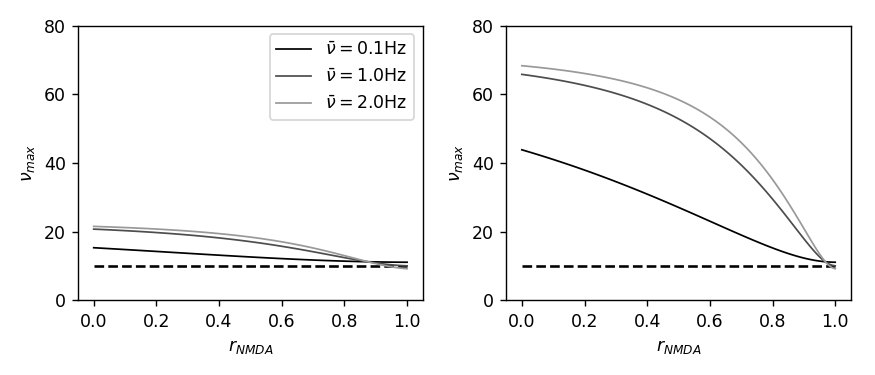

In [189]:
from general.transformParas import *

add_args = {'nu_I':2.,'tau_M':0.01,'tau_A':0.005,'tau_N':0.2,'tau_G':0.02,'kappa_E':4.}
add_args_2 = {'nu_I':2.,'tau_M':0.01,'tau_A':0.0005,'tau_N':0.2,'tau_G':0.02,'kappa_E':4.}

fig,ax = plt.subplots(1,2,figsize=(7,3))
r_arr = np.linspace(0,1,101)

ax[0].hlines(10,0,1,color='k',ls='--')
ax[1].hlines(10,0,1,color='k',ls='--')

for i,nu in enumerate([0.1,1.,2.]):
#for i,delta in enumerate([4.5,5.5,6.0,8.0]):
    col = 0.3*i

    tP = transformParas(**(add_args|{'nu_E':nu}))
#    tP = transformParas(**(add_args|{'gamma':1.4,'delta':delta}))
    ax[0].plot(r_arr,tP.get_nu_max(r_arr),color=[col,col,col],lw=1,label='$\\bar{\\nu}=%.1f$Hz'%tP.nu_mean)
    
    tP = transformParas(**(add_args_2|{'nu_E':nu}))
#    tP = transformParas(**(add_args_2|{'gamma':1.4,'delta':delta}))
    ax[1].plot(r_arr,tP.get_nu_max(r_arr),color=[col,col,col],lw=1,label='$\\bar{\\nu}=%.1f$Hz'%tP.nu_mean)
    
ax[0].legend()
for axx in ax:
    plt.setp(axx,ylim=[0,80],xlabel='$r_{NMDA}$',ylabel='$\\nu_{max}$')

plt.tight_layout()
fig.savefig("../figures/var_transform.pdf", bbox_inches='tight')
plt.show()

In [8]:
I.prepare_data(animal=12)
I.rates

array([0.32967033, 0.32967033, 0.32967033, 0.32967033, 0.38461538,
       0.38461538, 0.38461538, 0.38461538, 0.38461538, 0.38461538,
       0.38461538, 0.38461538, 0.38461538, 0.38461538, 0.38461538,
       0.38461538, 0.38461538, 0.38461538, 0.38461538, 0.38461538,
       0.38461538, 0.38461538, 0.38461538, 0.38461538, 0.38461538,
       0.38461538, 0.38461538, 0.65934066, 0.65934066, 0.76923077,
       0.76923077, 0.76923077, 0.76923077, 0.76923077, 0.76923077,
       0.76923077, 0.76923077, 0.76923077, 0.76923077, 0.76923077,
       0.76923077, 1.15384615, 1.15384615, 1.15384615, 1.15384615,
       1.15384615, 1.15384615, 1.15384615, 1.15384615, 1.15384615,
       1.15384615, 1.15384615, 1.53846154, 1.53846154, 1.53846154,
       1.53846154, 1.53846154, 1.92307692, 1.92307692, 2.30769231,
       2.69230769, 3.07692308, 4.61538462, 5.        , 8.46153846,
       9.23076923])

<IPython.core.display.Javascript object>


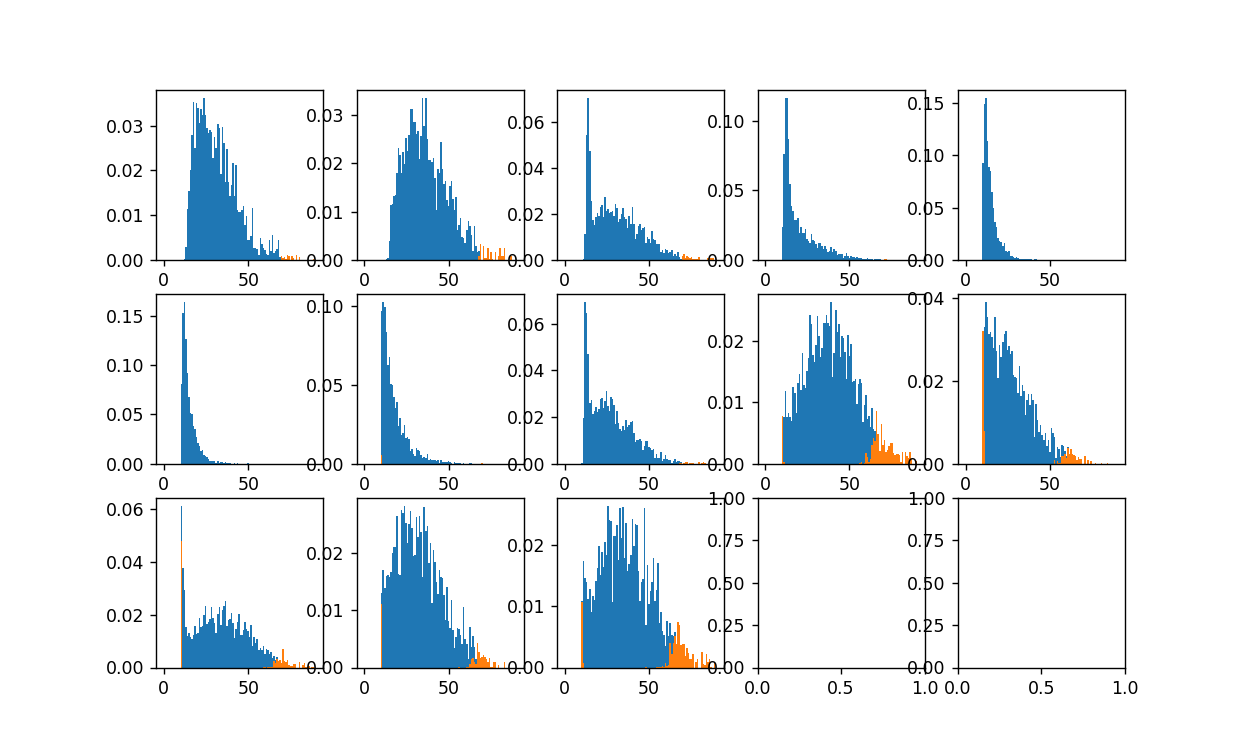

weight of unused data (animal 0): 0.007250597163712756
weight of unused data (animal 1): 0.0220648266150809
weight of unused data (animal 2): 0.016456706971399716
weight of unused data (animal 3): 0.002108408642332632
weight of unused data (animal 4): 7.006204826118553e-06
weight of unused data (animal 5): 6.868997609646983e-06
weight of unused data (animal 6): 0.0057208432164572815
weight of unused data (animal 7): 0.005414046843355056
weight of unused data (animal 8): 0.08431875749519216
weight of unused data (animal 9): 0.07332621408509621
weight of unused data (animal 10): 0.08608394857771204
weight of unused data (animal 11): 0.03893838942794702
weight of unused data (animal 12): 0.08312321557338875


In [176]:
#add_args = {'nu_I':1.,'tau_M':0.005,'tau_A':0.001,'tau_N':0.2,'tau_G':0.02,'kappa_E':4.}
#add_args = {'nu_I':2.,'tau_M':0.01,'tau_A':0.0002,'tau_N':0.2,'tau_G':0.02,'kappa_E':4.}
add_args = {'nu_I':2.,'tau_M':0.01,'tau_A':0.0005,'tau_N':0.2,'tau_G':0.02,'kappa_E':4.}

fileName = 'points_transformed'
for key,val in add_args.items():
    fileName += f"_{key}={val}"
fileName += '.pkl'


ncols = 5
nrows = 3
fig,ax = plt.subplots(nrows,ncols,figsize=(10,6))

for a in range(13):
    f = open(f"./logs_animal_{a}/run3/results/{fileName}",'rb')
    data_load = pickle.load(f)

    p = data_load['points'][:,2]
    p_T = data_load['points_transformed'][:,2]
    w = data_load['weights']
    
    mask = np.isnan(p_T)
    print(f"weight of unused data (animal {a}): {w[mask].sum()}")
    
    ax[a//ncols][a%ncols].hist(p,weights=w,bins=np.linspace(0,90,101))
    ax[a//ncols][a%ncols].hist(p[mask],weights=w[mask],bins=np.linspace(0,90,101))
plt.show()

<IPython.core.display.Javascript object>


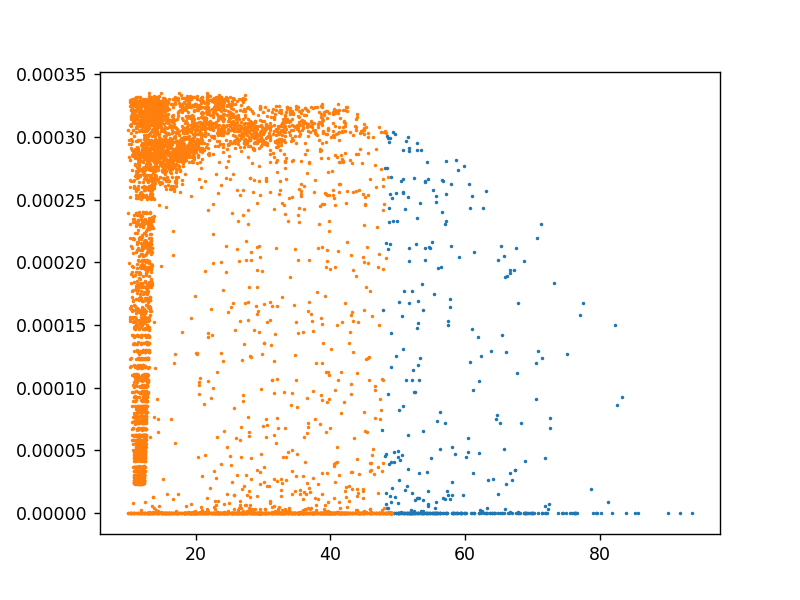

In [160]:
%matplotlib nbagg
plt.figure()
mask = np.isnan(p_T)
plt.scatter(p[mask],w[mask],s=1)
plt.scatter(p[~mask],w[~mask],s=1)
plt.show()

In [161]:
w[mask].sum()

0.030448420154973125

In [162]:
np.dot(p,w)

20.51744720576056

<IPython.core.display.Javascript object>


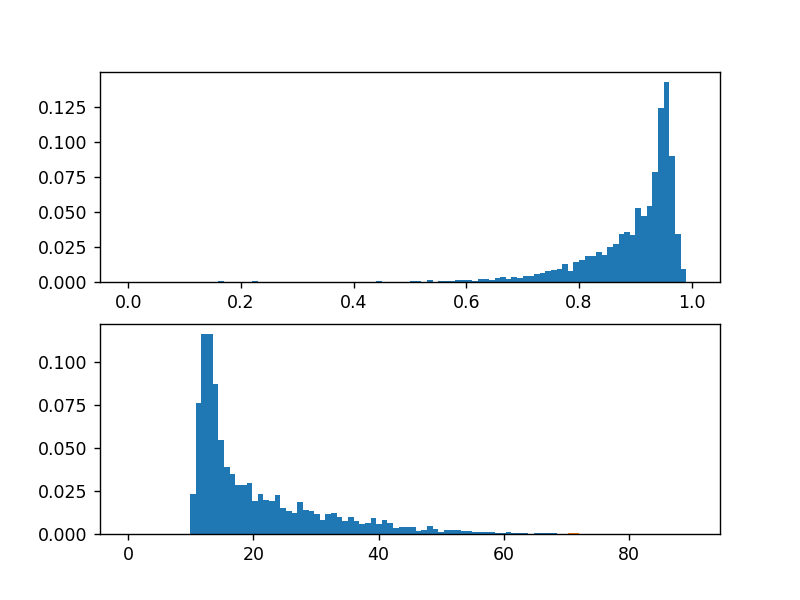

In [155]:
fig,ax = plt.subplots(2,1)
ax[0].hist(p_T,weights=w,bins=np.linspace(0,1,101))
ax[1].hist(p,weights=w,bins=np.linspace(0,90,101))
ax[1].hist(p[mask],weights=w[mask],bins=np.linspace(0,90,101))
plt.show()

In [46]:
data = {}
data['points'] = result['weighted_samples']['points']
data['weights'] = result['weighted_samples']['weights']
import pickle
f = open(b'./logs_animal_12/run2/results/points_transformed.pkl','wb')
pickle.dump(data,f)

NameError: name 'result' is not defined

In [17]:
f = open(b'./logs_animal_12/run2/results/points_transformed.pkl','rb')
data_load = pickle.load(f)

In [18]:
data_load

{'points': array([[ 0.09404946,  4.76388791, 58.55535609],
        [ 2.78155089,  3.49039812, 44.1872402 ],
        [ 2.63469588,  3.43534193, 54.17442612],
        ...,
        [ 0.82478793,  2.77930795, 10.00872929],
        [ 0.87059737,  2.92048178, 10.0301258 ],
        [ 0.83560455,  2.83143987, 10.03235884]]),
 'weights': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.75499378e-05, 3.81110993e-05, 3.87115355e-05])}

In [30]:
logp_prior = np.log(-0.5*(np.diff(np.exp(seq['logvol'][1:])) + np.diff(np.exp(seq['logvol'][:-1]))))

data = {}
data['logX'] = np.array(seq['logvol'][1:-1])
data['logl'] = np.array(seq['logl'][1:-1])
data['logZ'] = np.array(seq['logz'][1:-1])
data['logp_posterior'] = logp_prior + data['logl'] - data['logZ'][-1]
data['samples'] = seq['samples'][1:-1,:]

<IPython.core.display.Javascript object>


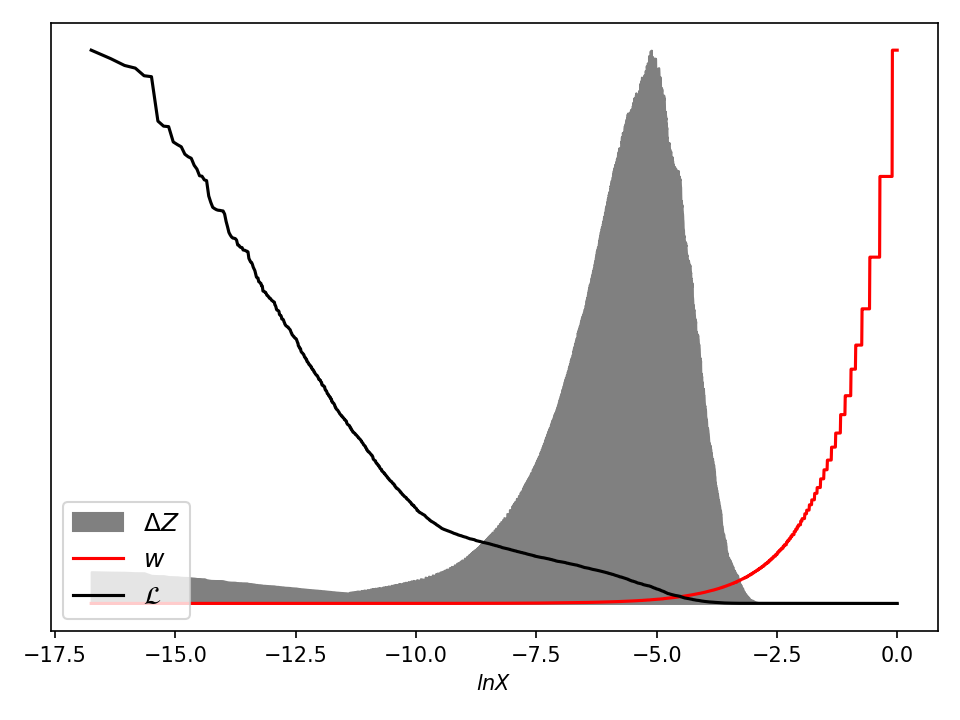

In [31]:
plt.figure()
ax1 = plt.subplot(111)

dZ = np.diff(np.exp(data['logZ']))
ax1.fill_between(data['logX'][1:],dZ/dZ.max(),color=[0.5,0.5,0.5],zorder=0,label='$\Delta Z$')

w = np.exp(logp_prior)
ax1.plot(data['logX'],w/w.max(),'r',zorder=5,label='$w$')

L = np.exp(data['logl'])
ax1.plot(data['logX'],L/L.max(),'k',zorder=10,label='$\mathcal{L}$')

ax1.set_yticks([])
ax1.set_xlabel('$ln X$')
plt.legend(fontsize=12,loc='lower left')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


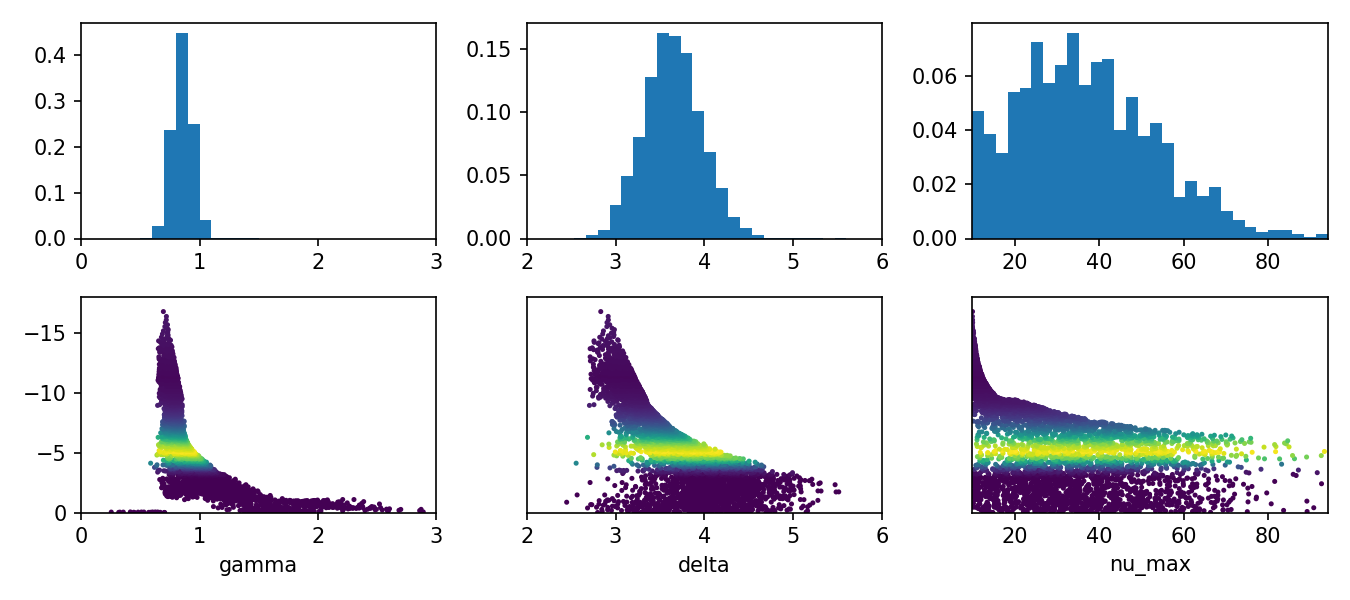

0.8531406427937138
3.642649184663859
37.05659208379755


In [32]:
data['samples'].shape
data['logX'].shape
fig,ax = plt.subplots(2,3,figsize=(9,4))

labels = ['gamma','delta','nu_max']
for i in range(3):
    points = result['weighted_samples']['points'][:,i]
    weights = result['weighted_samples']['weights']
    
    print((points * weights).sum())
    data_min = np.floor(min(points))
    data_max = np.ceil(max(points))
    
    bins = np.linspace(data_min,data_max,31)
    
    ax[0,i].hist(points,weights=weights,bins=bins)
    plt.setp(ax[0,i],xlim=[data_min,data_max])
    
    ax[1,i].scatter(data['samples'][:,i],data['logX'],c=np.exp(data['logp_posterior']),s=2)
    plt.setp(ax[1,i],xlim=[data_min,data_max],ylim=[0,-18],xlabel=labels[i])
    if i>0:
        ax[1,i].set_yticks([])
    plt.tight_layout()
plt.show()

In [33]:
np.exp(data['logp_posterior'])

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       5.08754357e-05, 5.15193706e-05, 2.61609740e-05])

In [42]:
result['weighted_samples']['weights']

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       5.15139444e-05, 5.23164373e-05, 5.30061570e-05])

<IPython.core.display.Javascript object>


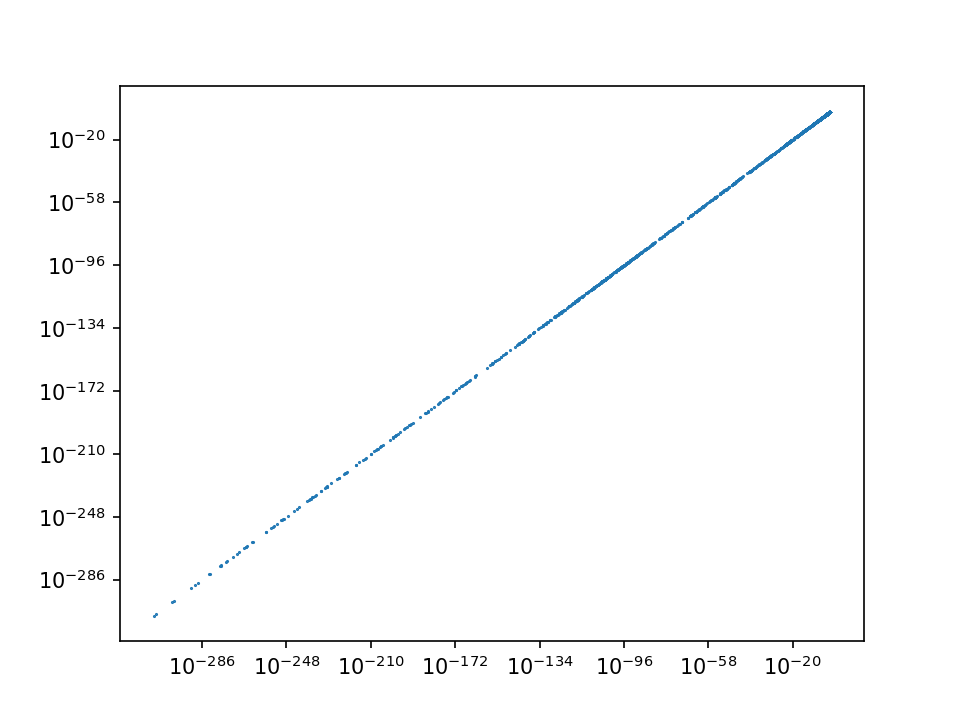

In [40]:
plt.figure()
plt.plot(result['weighted_samples']['weights'][1:-1],np.exp(data['logp_posterior']),'.',markersize=1)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [9]:
#import multiprocessing as mp
from general.transformParas import *

add_args = {'nu_I':2.,'tau_M':0.01,'tau_A':0.001,'tau_N':0.2,'tau_G':0.02,'r':0.,'kappa_E':4.}
tP = transformParas()
tP.updateParas(add_args)

#print(r)
#r = np.zeros(data['samples'].shape[0])
#for i,(g,d,n) in enumerate(data['samples']):
#    tP.updateParas({'gamma':g,'delta':d,'nu_max':n})
#    r[i] = tP.get_r_NMDA()

In [287]:
# run with multiple processors
pool = mp.get_context("spawn").Pool(12)
r = pool.starmap(tP.returnParas,zip(data['samples']))

/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:55: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:55: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/general/transformParas.py:55: RuntimeWarning: invalid value encountered in sqrt
  self.alpha_0 = np.sqrt(self.J_0**2 * ( self.nu_mean/ (2 * self.gamma**2 * (self.tau_A + self.tau_M)) - q))


In [292]:
r = np.array(r)

# Watch out: nu_max is defined in spikes/minute, not seconds. timescales are in secs -> consolidate!

In [10]:

add_args = {'nu':1.,'nu_I': 2.,'tau_M':0.01,'tau_A':0.001,'tau_N':0.2,'r':0.,'kappa_E':1.}
tP = transformParas()
tP.updateParas(add_args)
#tP.get_r_NMDA()
tP.returnParas({'gamma':[1.0555,1.4],'delta':[3.2,4.5],'nu_max':[27.,35]})

KeyError: 0

In [ ]:
fig,ax = plt.subplots(1,2)
bins = np.linspace(0,1,51)
ax[0].hist(r[:,2],bins=bins)
ax[1].hist(r[:,2],weights=result['weighted_samples']['weights'][1:-1],bins=bins)
plt.show()

In [ ]:
result['weighted_samples']['weights'].shape

In [19]:
nA = 13#I.data.shape[1]
res = {
    'gamma': {
        'mean': np.zeros(nA),
        'std': np.zeros(nA),
    },
    'delta': {
        'mean': np.zeros(nA),
        'std': np.zeros(nA),
    },
    'nu_max': {
        'mean': np.zeros(nA),
        'std': np.zeros(nA),
    }
}

for a in range(13):#I.data.shape[1]):
    fname = f"./logs_animal_{a}/run3/info/results.json"
    with open(fname) as f:
        data = json.load(f)
        
        for i,key in enumerate(['gamma','delta','nu_max']):
            res[key]['mean'][a] = data['posterior']['mean'][i]
            res[key]['std'][a] = data['posterior']['stdev'][i]

In [86]:
res['nu_max']['mean'][11]

31.698673920183563

In [76]:
weights.sum()

0.9999999999999178

NameError: name 'gamma' is not defined

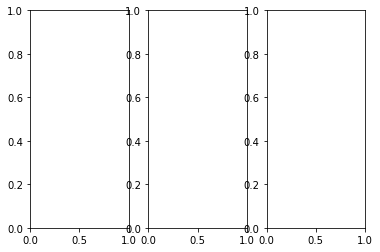

In [87]:
idx_WT = [4,5,6,7]
idx_AP = [0,1,2,3]
idx_cTKO = [8,9,10,11,12]

fig,ax = plt.subplots(1,3)
ax[0].errorbar(np.ones_like(idx_WT)+np.random.rand(4),gamma[idx_WT,0],yerr=(gamma[idx_WT,1:]-gamma[idx_WT,0:1]).T,color='k',ls='none')
ax[0].plot(np.ones_like(idx_AP)*2,gamma[idx_AP,0],'go')
ax[0].plot(np.ones_like(idx_cTKO)*3,gamma[idx_cTKO,0],'ro')

ax[1].plot(np.ones_like(idx_WT),delta[idx_WT,0],'ko')
ax[1].plot(np.ones_like(idx_AP)*2,delta[idx_AP,0],'go')
ax[1].plot(np.ones_like(idx_cTKO)*3,delta[idx_cTKO,0],'ro')

ax[2].plot(np.ones_like(idx_WT),nu_max[idx_WT,0],'ko')
ax[2].plot(np.ones_like(idx_AP)*2,nu_max[idx_AP,0],'go')
ax[2].plot(np.ones_like(idx_cTKO)*3,nu_max[idx_cTKO,0],'ro')
plt.show()

In [11]:
tP = transformParas(1.2,4.2,22.)

In [12]:
tP.updateParas({'tau_A':0.001,'gamma':1.26,'delta':4.5,'nu_max':45/60})
tP.get_r_NMDA()

nan

In [136]:
I.data_df

*mouse_type          LM (APLP1 KO)                          \
animal      20180325 (app ko7 739) 20180325A (app ko8 740)   
0                              0.0                     0.0   
1                              0.0                     0.0   
2                              0.0                     0.0   
3                              0.0                     0.0   
4                              0.0                     0.0   
..                             ...                     ...   
365                            NaN                     NaN   
366                            NaN                     NaN   
367                            NaN                     NaN   
368                            NaN                     NaN   
369                            NaN                     NaN   

*mouse_type                                                         WT  \
animal      20180402A (app ko13 734) 20180419 (app ko14 756) 20180310A   
0                                0.0                     0.0       0.0   
1                                0.0                     0.0       0.0   
2                                0.0                     0.0       0.0   
3                                0.0                     0.0       0.0   
4                                0.0                     0.0       0.0   
..                               ...                     ...       ...   
365                              NaN                     NaN       NaN   
366                              NaN                     NaN       NaN   
367                              NaN                     NaN       NaN   
368                              NaN                     NaN       NaN   
369                              NaN                     NaN       NaN   

*mouse_type                                  cTKO                              \
animal      20180310B 20180312A 20180401 20180309 20180310  20180311 20180329   
0                 0.0       0.0      0.0      0.0      0.0  0.000000      0.0   
1                 0.0       0.0      0.0      0.0      0.0  0.000000      0.0   
2                 0.0       0.0      0.0      0.0      0.0  0.000000      0.0   
3                 0.0       0.0      0.0      0.0      0.0  0.000000      0.0   
4                 0.0       0.0      0.0      0.0      0.0  0.000000      0.0   
..                ...       ...      ...      ...      ...       ...      ...   
365               NaN       NaN      NaN      NaN      NaN  6.153846      NaN   
366               NaN       NaN      NaN      NaN      NaN  6.153846      NaN   
367               NaN       NaN      NaN      NaN      NaN  6.923077      NaN   
368               NaN       NaN      NaN      NaN      NaN  7.307692      NaN   
369               NaN       NaN      NaN      NaN      NaN  8.076923      NaN   

*mouse_type            
animal      20180329A  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  
..                ...  
365               NaN  
366               NaN  
367               NaN  
368               NaN  
369               NaN  

[370 rows x 13 columns]

/tmp/ipykernel_199670/3224483873.py:4: RuntimeWarning: divide by zero encountered in log
  return gamma / ( nu_max * np.sqrt( -np.pi * np.log( nu / nu_max ) ) ) * \
/tmp/ipykernel_199670/3224483873.py:6: RuntimeWarning: divide by zero encountered in log
  np.cosh( gamma * delta * np.sqrt( -2 * np.log( nu / nu_max) ) )
/tmp/ipykernel_199670/3224483873.py:4: RuntimeWarning: invalid value encountered in multiply
  return gamma / ( nu_max * np.sqrt( -np.pi * np.log( nu / nu_max ) ) ) * \


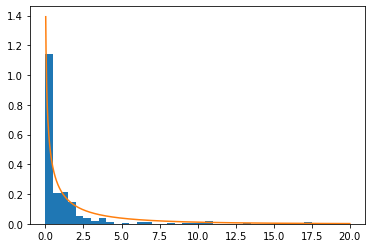

In [22]:
plt.hist(I.data[:,1],np.linspace(0,20,41),density=True)
nu_arr = np.linspace(0,20,1001)
plt.plot(nu_arr,p_nu(nu_arr,1.46,3.71,27.92))
plt.show()

In [28]:
trafo = I.setPriorTransform()
trafo(np.random.rand(10,3))

array([[  0.75607408,   3.42825043,  72.0484767 ],
       [  1.73287295,   3.60684533, 104.53933117],
       [  1.80884329,   4.27850686,  15.69271612],
       [  0.91990877,   3.55685496,  52.46742652],
       [  2.10199671,   3.56393846,  60.70995248],
       [  2.69340341,   4.02459878,  12.8520792 ],
       [  1.67867565,   4.63330321,  21.90654453],
       [  1.30245563,   3.7190702 ,  67.15884946],
       [  1.6540832 ,   3.59150864,  49.10787112],
       [  1.06636871,   4.23933503,  49.73194162]])

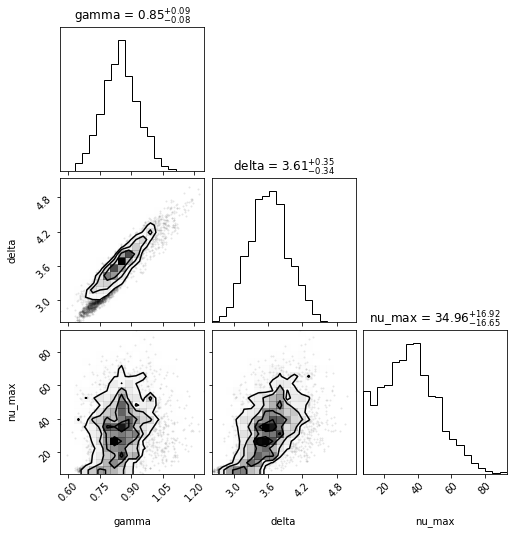

In [42]:
from ultranest.plot import cornerplot
cornerplot(result)

In [49]:
plt.figure()
sampler.plot_run()
sampler.plot_trace()
sampler.plot_corner()
plt.show()

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>


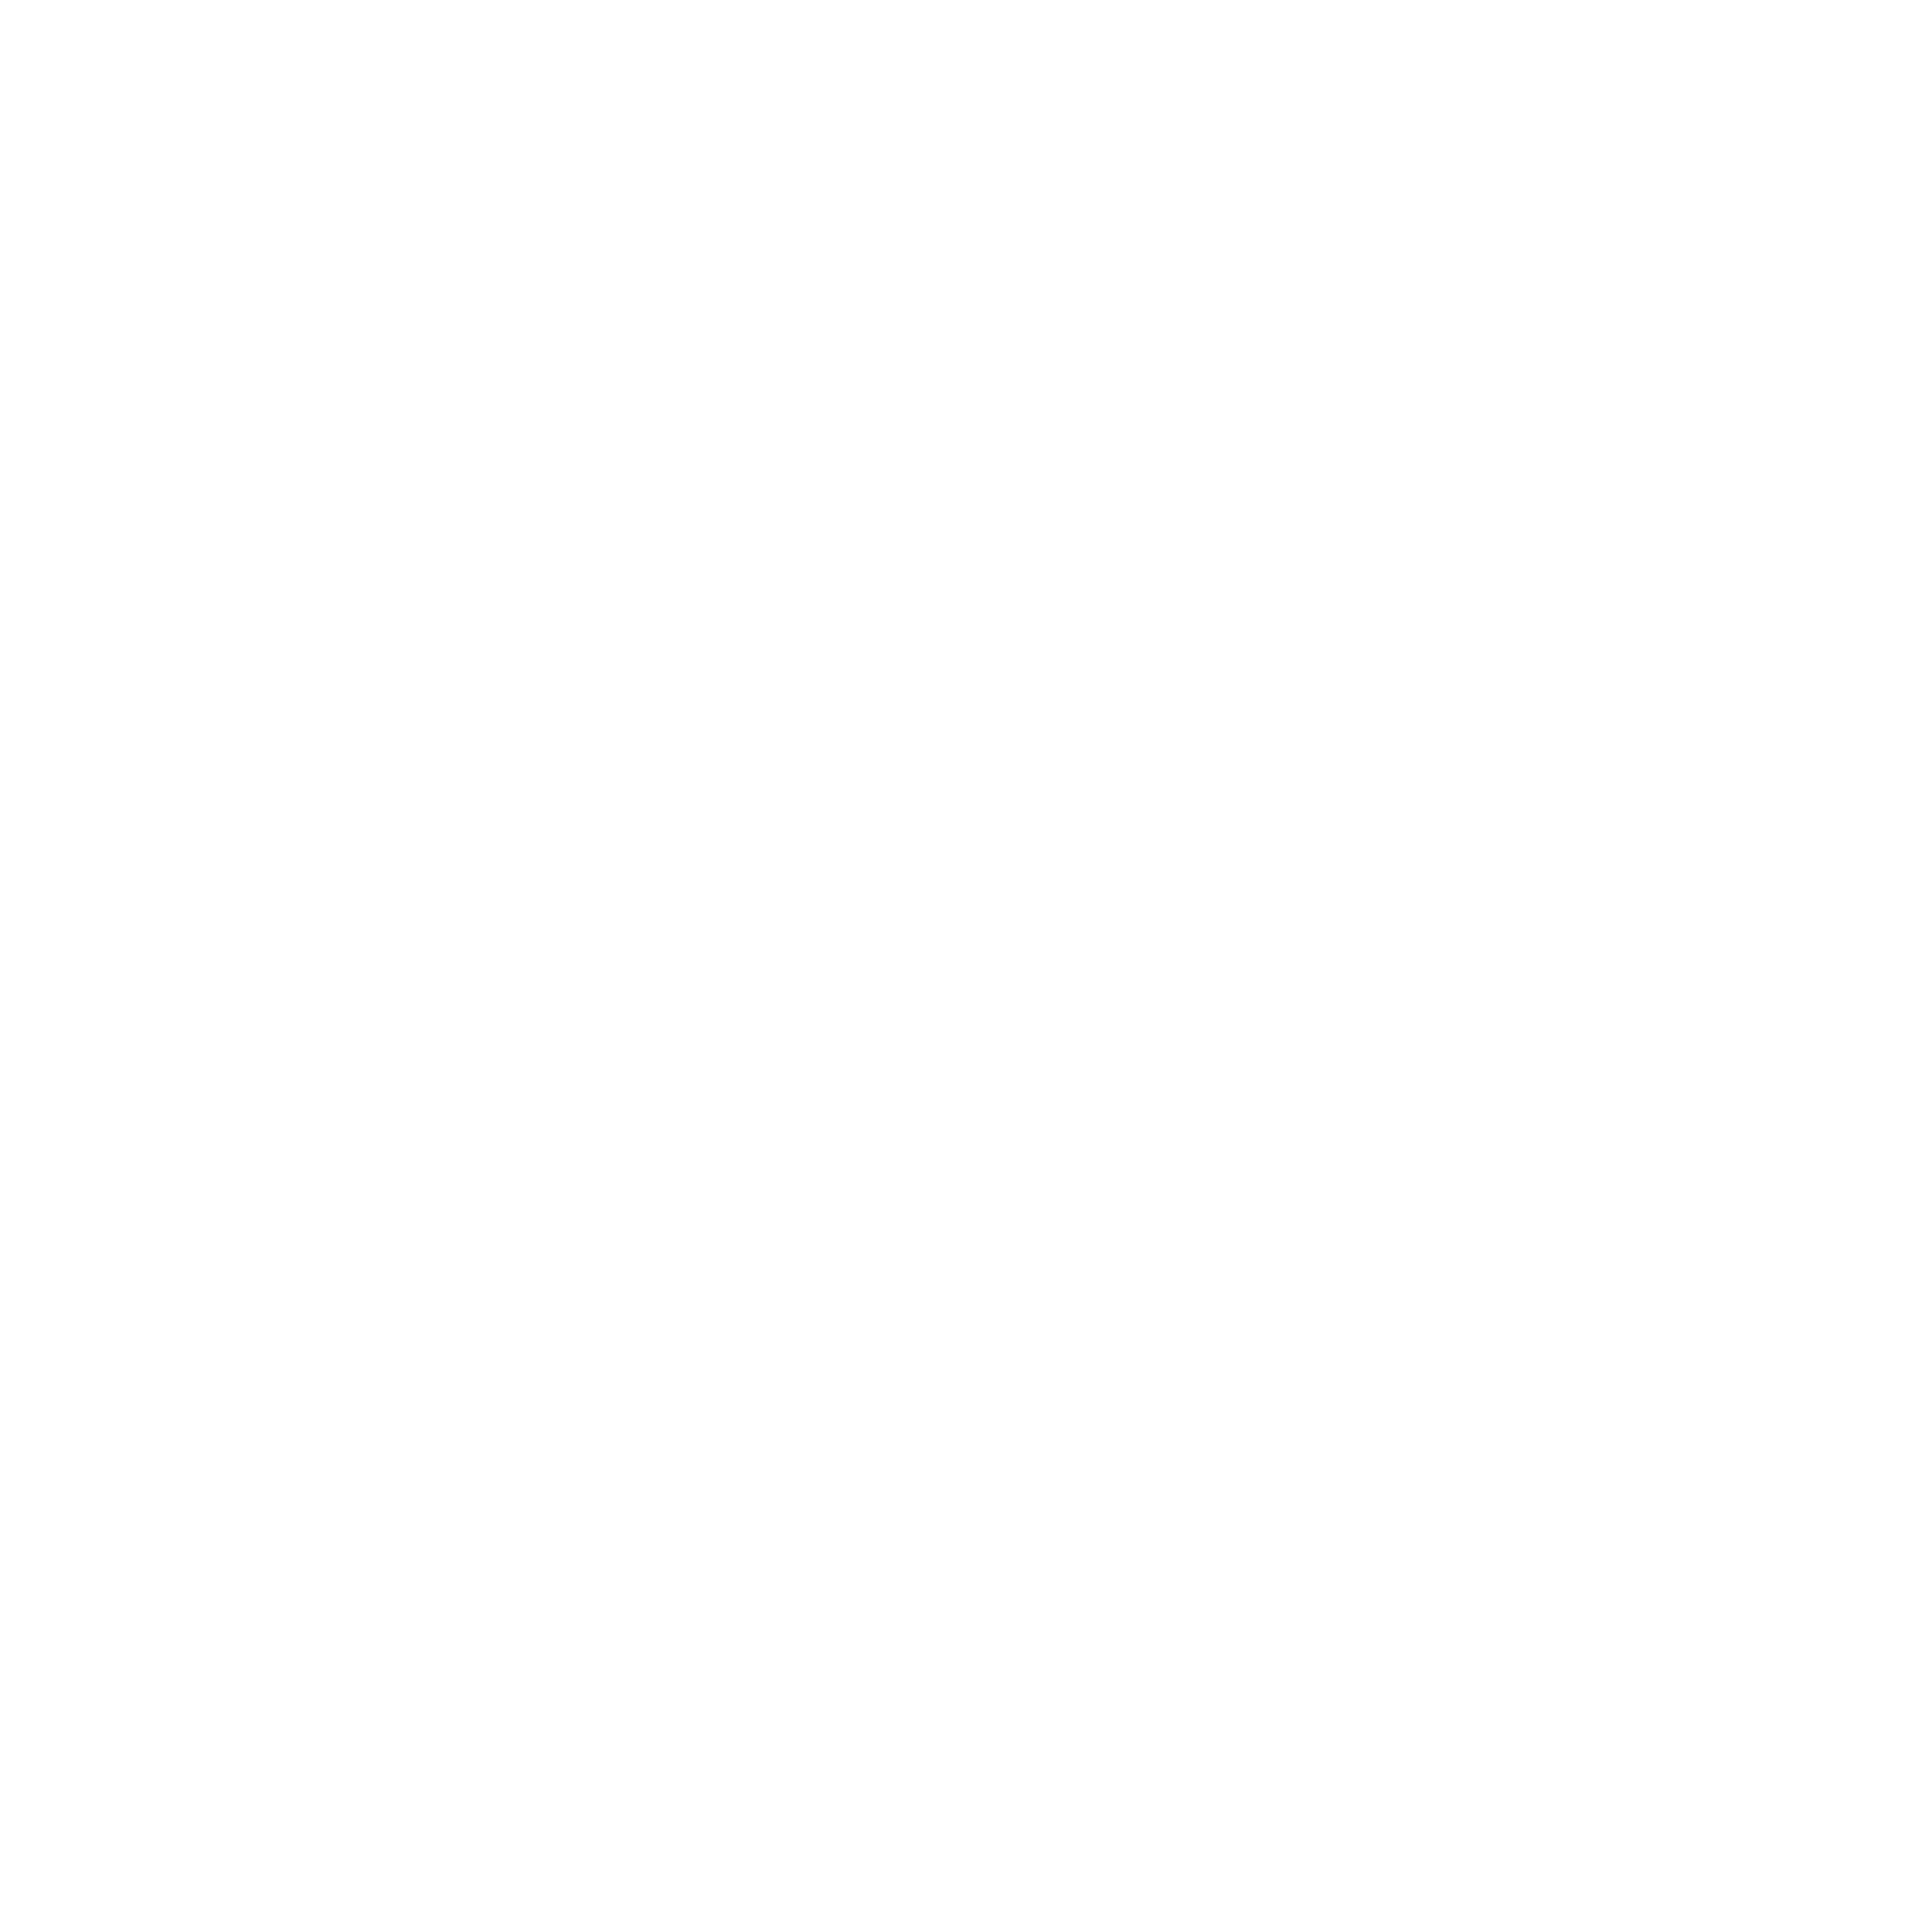

In [51]:
%matplotlib nbagg
sampler.

In [10]:
sampler.print_results()


logZ = -118582.967 +- 0.459
  single instance: logZ = -118582.967 +- 0.272
  bootstrapped   : logZ = -118582.958 +- 0.459
  tail           : logZ = +- 0.010
insert order U test : converged: False correlation: 1110 iterations

    gamma               : 1.2707│ ▁▁▁▁▁▁▁▁▁▁▂▂▃▃▅▆▆▇▆▇▇▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁ │1.3318    1.3015 +- 0.0068
    delta               : 1.416 │▁▁▁▁▁▁▁▁▁▁▂▃▄▄▅▆▆▇▇▆▆▅▅▃▃▂▁▁▁▁▁▁▁▁   ▁ │1.525     1.467 +- 0.012
    nu_max              : 18.158│ ▁   ▁▁▁▁▁▁▁▂▂▃▄▅▄▆▇▇▇▆▅▅▄▂▂▂▁▁▁▁▁▁▁ ▁ │18.871    18.534 +- 0.076



In [20]:
result.keys()

dict_keys(['niter', 'logz', 'logzerr', 'logz_bs', 'logz_single', 'logzerr_tail', 'logzerr_bs', 'ess', 'H', 'Herr', 'posterior', 'weighted_samples', 'samples', 'maximum_likelihood', 'ncall', 'paramnames', 'logzerr_single', 'insertion_order_MWW_test'])

In [76]:
gamma = 1.5#np.array([1.5,1.7])
delta = 4.2#np.array([4.2,4.5])
nu_max = 40.#np.array([40.,50.])

N_AP = np.array([10,20,0,3])[:,np.newaxis,np.newaxis]
T_total = 10.

def f(nu):#,gamma,delta,nu_max,N_AP,T_total):
    #print(p_nu(nu,gamma,delta,nu_max))
    #print(p_nu(nu,gamma,delta,nu_max)[np.newaxis,...].shape)
    #print(poisson_spikes(nu,N_AP,T_total).shape)
    return p_nu(nu,gamma,delta,nu_max)[np.newaxis,...] * poisson_spikes(nu,N_AP,T_total)

eps_pow = -8
#p_N_AP_arr, err = quadpy.quad(f,[0],[nu_max[0]],
p_N_AP_arr, err = quadpy.c1.integrate_adaptive(f,[[0,0.2],[nu_max,nu_max]],
   domain_shape=(2,),#range_shape=(2,),
    #args=(gamma,delta,nu_max,N_AP,T_total),
    eps_abs=10**eps_pow, eps_rel=10**eps_pow)
#    limit=100)
p_N_AP_arr

array([[0.03030462, 0.03045599],
       [0.01492237, 0.01499735],
       [0.19635129, 0.01126758],
       [0.07444188, 0.05675328]])

poisson: [ 0.     0.041  0.082 ... 40.918 40.959 41.   ] 10


/tmp/ipykernel_70991/580719938.py:2: RuntimeWarning: divide by zero encountered in log
  return gamma / ( nu_max * np.sqrt( -np.pi * np.log( nu / nu_max ) ) ) * \
/tmp/ipykernel_70991/580719938.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return gamma / ( nu_max * np.sqrt( -np.pi * np.log( nu / nu_max ) ) ) * \
/tmp/ipykernel_70991/580719938.py:4: RuntimeWarning: divide by zero encountered in log
  np.cosh( gamma * delta * np.sqrt( -2 * np.log( nu / nu_max) ) )
/tmp/ipykernel_70991/580719938.py:2: RuntimeWarning: invalid value encountered in multiply
  return gamma / ( nu_max * np.sqrt( -np.pi * np.log( nu / nu_max ) ) ) * \
/tmp/ipykernel_70991/580719938.py:8: RuntimeWarning: divide by zero encountered in log
  return np.exp(N*np.log(nu*T_total) - np.log(sp_factorial(N)) - nu*T_total)


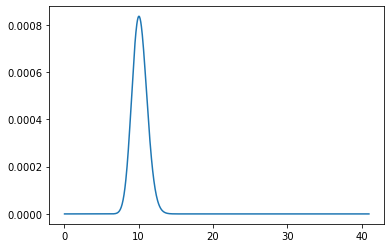

In [16]:
nu_arr = np.linspace(0,41,1001)
plt.plot(nu_arr,p_nu(nu_arr,1.63,1.63,41.)*poisson_spikes(nu_arr,100,10))
plt.show()

In [26]:
n = 300
N_AP_max = 200
N_AP = np.arange(0,N_AP_max)[:,np.newaxis]
k_AP = np.array(np.random.randint(0,100,N_AP_max))
T_total = 10

eps_pow = -6

def my_likelihood(params):
    
    gamma, delta, nu_max = params
    ## define likelihood based on parameters, with data provided from context
    # integrate rho_nu with poisson
    
    def f(nu,gamma,delta,nu_max,N_AP,T_total):
        return p_nu(nu,gamma,delta,nu_max)[np.newaxis,:] * poisson_spikes(nu,N_AP,T_total)
    
    fail = True
    eps_pow = -8
    while True:
        if eps_pow==-1:
            print('tolerance too high - breaking!')
            output = np.ones_like(inputs[0])*(-100)
            break
        try:
            p_N_AP_arr, err = quadpy.quad(f,[0],[nu_max],
                args=(gamma,delta,nu_max,N_AP,T_total),
                epsabs=10**eps_pow, epsrel=10**eps_pow, 
                limit=100)
            break
        except:
            eps_pow += 1
    
    #print(p_N_AP_arr)
    # calculate chance to appear k times
    p_k = sp_binom(n,k_AP) * p_N_AP_arr**k_AP * (1-p_N_AP_arr)**(n - k_AP)
    #p_k[p_k==0] = 10**(-300)
    return np.log(p_k[p_k>0])

